# Lab: CNN Visualization
*Mark Brubaker & Eli Mann*

 ## In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet).
*These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.) https://keras.io/api/applications/Links to an external site.*
*It is recommended to select a model with somewhat simple structure, like VGG. This can help to simplify how to extract specific filters and inputs to filters later on.*
*Explain the model you chose and why.  Classify a few images with pre-trained network to verify that it is working properly.*

 ## Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit.
*This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are a few convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: https://microscope.openai.com/models/Links to an external site.*
* *Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class:https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynbLinks to an external site.*
* *Also send images of varying class (i.e. from ImageNet) through the network and track which classes of images most excite your chosen filter.*
* *Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network?*
* *If using code from another source, you must heavily document the code so that I can grade your understanding of the code used.*

## Analyze each channel of the multi-channel filter to this feature that might form a circuit.
*That is, visualize the convolutional filter (one channel) between the input activations and the current activation to understand which inputs make up a circuit. One method of doing this is given below:*
* *Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5.*
* *Keep the top six sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top six filters.*
* *For these six strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?*

## For each of the six chosen single channels of the filter, use image gradient techniques to visualize what each of these filters is most excited by
*That is, what image maximally excites each of these filters. This is a similar analysis to the first step, but now isolating the filters directly before your chosen filter.*
* *Use these visualizations, along with the circuit weights you just discovered to try and explain how this particular circuit works. An example of this visualization style can be seen here: https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/mixed3b_379.htmlLinks to an external site.*
* *Try to define the properties of this circuit using vocabulary from https://distill.pub/2020/circuits/zoom-in/Links to an external site. (such as determining if this is polysemantic, pose-invariant, etc.)*
* *Relate your visualizations back to your original hypothesis about what this filter is extracting. Does it support or refute your hypothesis? Why?*

# Visualizing an Convolutional Neural Network using Curcuits

For this analysis we will be visualizing the VGG19 model. VGG19 is a convolutional neural network that is trained on the ImageNet dataset. We chose this model as it has been trained on a large dataset, and does not have residual connections. This makes it easier to visualize the circuits. We will be using the OpenAI microscope to select a filter to analyze. 

In [12]:
# import vgg19 pretrained model from keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np
import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import models

from PIL import Image
import os

In [13]:
# load the model
model = VGG19(weights='imagenet', include_top=True)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1/1 [==============================] - 0s 202ms/step


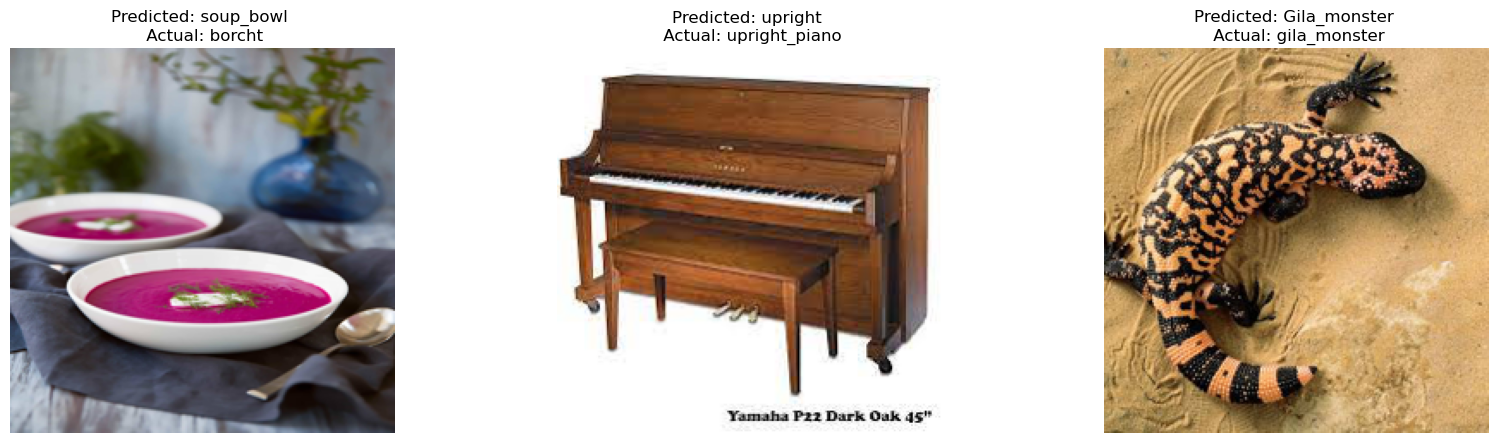

In [14]:

path = 'images/'

# Set up the plot grid
fig, axs = plt.subplots(1, len(os.listdir(path)), figsize=(20, 5))

# Iterate through the images and plot them
for i, filename in enumerate(os.listdir(path)):
    img = Image.open(os.path.join(path, filename)).resize((224, 224))
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    axs[i].imshow(img)
    axs[i].set_title(f'Predicted: {decode_predictions(preds, top=1)[0][0][1]} \n Actual: {filename.split(".")[0]}')
    axs[i].axis('off')

plt.show()


VGG19 has 19 layers, and we will be analyzing a multi-channel filter from the the 12th called 'block4_conv4' layer since it is a mid-level layer - it has several convolutional layers before and after it.

In [23]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)

        
    return new_img.astype('uint8')


def generate_pattern(layer_name, filter_index, size=150):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(40):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            loss = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(loss, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

In [24]:
plt.imshow(generate_pattern('block1_conv1', 8))
plt.show()

ValueError: Input 0 of layer "model_7" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 150, 150, 3)

In [10]:
layer_name  = 'block4_conv4'
size = 64
margin = 5

# This a empty (black) image where we will store our results.
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)).astype('uint8')

for i in range(8):  # iterate over the rows of our results grid
    for j in range(8):  # iterate over the columns of our results grid
        # Generate the pattern for filter `i + (j * 8)` in `layer_name`
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        # Put the result in the square `(i, j)` of the results grid
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

# Display the results grid
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.title(layer_name)
plt.show()

ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 64, 64, 3)